<a href="https://colab.research.google.com/github/cdrowley/notebook-demos/blob/main/roads_to_rome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/bellockk/alphashape.git --quiet # dev fix alphashape for shapely 2.0

In [2]:
import ast
import hashlib

import alphashape
import folium
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx
import pandas as pd
import shapely
from descartes import PolygonPatch
from shapely.geometry import Point


def generate_node_id(value):
    value_as_bytes = str(value).encode("utf-8")
    return hashlib.sha256(value_as_bytes).hexdigest()

## Raw Data Acquisition & Cleaning

[`dataverse_files.zip` Source](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TI0KAU)

In [3]:
# tmp_gdf = (
#     gpd.read_file("dataverse_files.zip")
#     .rename({"Shape_Leng": "geom_length"}, axis="columns")
#     .to_crs("EPSG:4326")
# )

# tmp_gdf.columns = [c.lower() for c in tmp_gdf.columns]

# tmp_gdf.to_parquet("data/roman_roads.parquet.gzip", compression="gzip")

# tmp_gdf.head(1)

## Load Data

Load data, get start and end point of each linestring and assign each a hashed ID

In [4]:
gdf = gpd.read_parquet("data/roman_roads.parquet.gzip")
gdf = gdf.assign(
    # create geometry points for the start (u_geom) and end (v_geom) of each linestring
    u_geom=[Point(geom.coords[0]) for geom in gdf["geometry"]],
    v_geom=[Point(geom.coords[-1]) for geom in gdf["geometry"]],
    # generate hashed ids for the start (u) and end (v) points
    u=[generate_node_id(geom.coords[0]) for geom in gdf["geometry"]],
    v=[generate_node_id(geom.coords[0]) for geom in gdf["geometry"]],
)

## Map it

In [6]:
g = gdf[["certainty", "geometry", "u_geom", "v_geom"]]

m = g.drop(columns=["u_geom", "v_geom"]).explore(
    column="certainty",
    tiles="CartoDB dark_matter",
    legend=True,
    name="Edges - Roman Roads",
)

# to add nodes:

g.set_geometry("u_geom").drop(columns=["v_geom", "geometry"]).explore(
    m=m, legend=True, name="Nodes - Start", color="white", marker_kwds={"radius": 0.2}
)

g.set_geometry("v_geom").drop(columns=["u_geom", "geometry"]).explore(
    m=m, legend=True, name="Nodes - End", color="white", marker_kwds={"radius": 0.2}
)

folium.LayerControl().add_to(m)
m

## Create networkx graph

In [7]:
u = gdf[["u_geom", "u"]].rename(
    columns={"u_geom": "geometry", "u": "osmid"}
)  # start node
v = gdf[["v_geom", "v"]].rename(
    columns={"v_geom": "geometry", "v": "osmid"}
)  # end node

nodes = (  # each linestring start/end point being a node
    gpd.GeoDataFrame(pd.concat((u, v)), crs="EPSG:4326")
    .set_index("osmid")
    .drop_duplicates(subset=("geometry"))  # remove duplicate nodes
    .assign(x=lambda df: df["geometry"].x, y=lambda df: df["geometry"].y)
)

edges = (  # each linestring being an edge, starting/ending at a node
    gdf[["u", "v", "objectid", "geometry"]]
    .rename(columns={"objectid": "key"})
    .set_index(["u", "v", "key"])
)

graph_attrs = {"crs": "epsg:4326", "simplified": True}
G = osmnx.graph_from_gdfs(nodes, edges[["geometry"]], graph_attrs)
print(G)

MultiDiGraph with 5122 nodes and 7154 edges


Export for use in [Gephi](https://gephi.org/)

In [8]:
g = nx.Graph()

for u, v, data in G.edges(data=True):  # Add edges to the export graph
    g.add_edge(u, v)  # **data

for node in g.nodes():  # Add node attributes
    g.nodes[node]["x"] = nodes.loc[node, "x"]
    g.nodes[node]["y"] = nodes.loc[node, "x"]

nx.write_gexf(g, "roman_road_network.gexf")

## Network centralities

Calculate the degree (number of connected edges) for each node in the graph.

Result: `{node_id: degree_count, ...}`

In [9]:
node_degrees = dict(g.degree)

Calculate the betweenness centrality (measures the extent to which a node lies on paths between other nodes) for each node in the graph. Computed here as the number of shortest paths passing through the node.

Result: `{node_id: betweenness_score}`

`normalized=False` meaning count absolute number of paths, not proportion.

In [10]:
node_betweenness = dict(nx.betweenness_centrality(g, normalized=False))

## Get Rome Admin Boundary

In [11]:
rome_admin = osmnx.geocode_to_gdf("Rome, Italy")

m = rome_admin.explore(color="red")
gpd.sjoin(
    gdf.drop(columns=["u_geom", "v_geom"]),
    rome_admin,
    how="inner",
    predicate="intersects",
).explore(m=m)

## Convex Hull Roman Roads Extent

In [ ]:
sample = nodes.sample(500)

points = list(zip(sample.geometry.x.to_list(), sample.geometry.y.to_list()))
alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

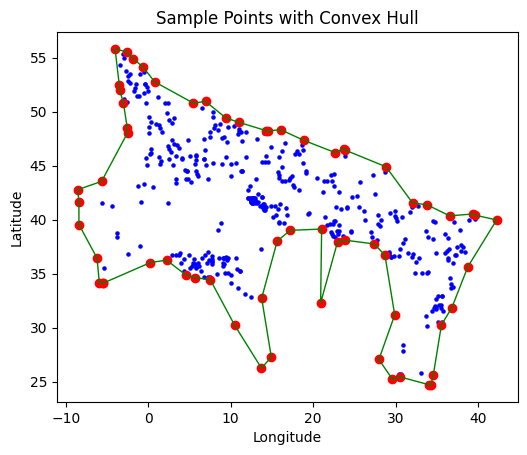

In [40]:
ax = sample.plot(color="blue", markersize=5)

# Extract hull points for the scatter plot
hull_pts = hull.exterior.coords.xy
ax.scatter(hull_pts[0], hull_pts[1], color="red")

# PolygonPatch not updated to shapely 2.0, use geojson interface instead
hull_to_dict = ast.literal_eval(shapely.to_geojson(hull))
ax.add_patch(PolygonPatch(hull_to_dict, fill=False, color="green"))

ax.set_title("Sample Points with Convex Hull")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## H3 Fill Convex Hull

In [50]:
def split_admin_boundary_to_hexagons(polygon, resolution):
    coords = list(polygon.exterior.coords)
    admin_geojson = {"type": "Polygon", "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, resolution, geo_json_conformant=True)
    hexagon_geometries = {
        hex_id: shapely.Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
        for hex_id in hexagons
    }
    return gpd.GeoDataFrame(hexagon_geometries.items(), columns=["hex_id", "geometry"])


roman_empire = split_admin_boundary_to_hexagons(hull, 3).set_crs("EPSG:4326")
roman_empire.explore()

# TODO, tidy:

## Plot Degree / Centrality


In [51]:
gdf_merged = gpd.sjoin(roman_empire, nodes[["geometry"]])
gdf_merged["degree"] = gdf_merged.index_right.map(node_degrees)
gdf_merged["betweenness"] = gdf_merged.index_right.map(node_betweenness)
gdf_merged = gdf_merged.groupby(by="hex_id")[["degree", "betweenness"]].sum()
gdf_merged.head(3)

degree   betweenness
hex_id                               
831845fffffffff      10  9.380841e+04
831849fffffffff      27  1.212578e+06
83184dfffffffff      28  5.398921e+05

In [52]:
roman_empire = roman_empire.merge(
    gdf_merged, left_on="hex_id", right_index=True, how="outer"
)
roman_empire = roman_empire.fillna(0)

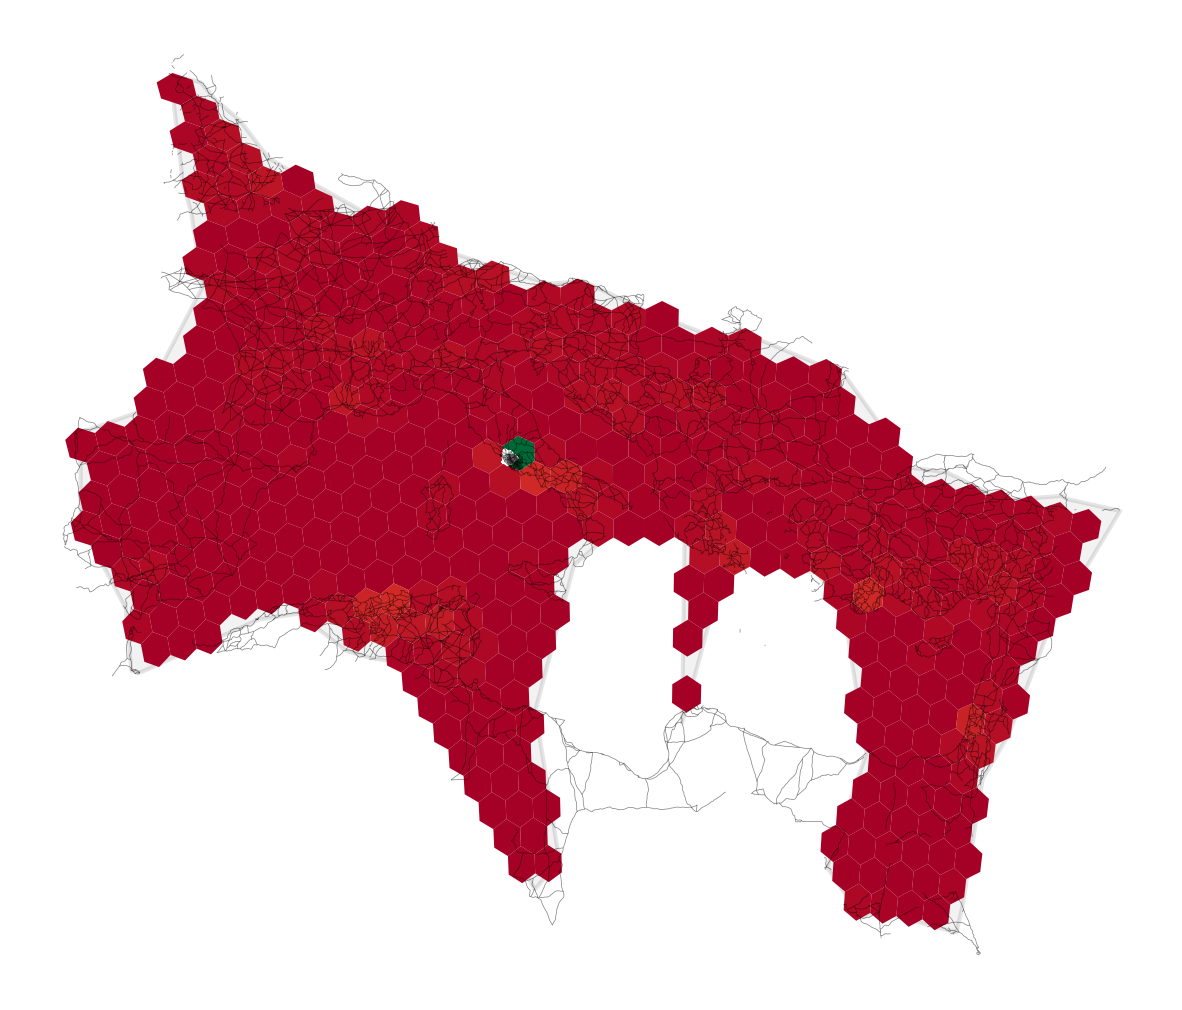

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot hull
gpd.GeoDataFrame([hull], columns=["geometry"]).plot(
    ax=ax, color="grey", edgecolor="k", linewidth=3, alpha=0.1
)

# Plot h3 cells
roman_empire.plot(column="degree", cmap="RdYlGn", ax=ax)

# Plot road network
gdf.plot(ax=ax, color="k", linewidth=0.5, alpha=0.5)

# Plot rome_admin boundary
rome_admin.plot(ax=ax, color="white", linewidth=3, edgecolor="white")

ax.axis("off")
plt.savefig("degree.png", dpi=600)

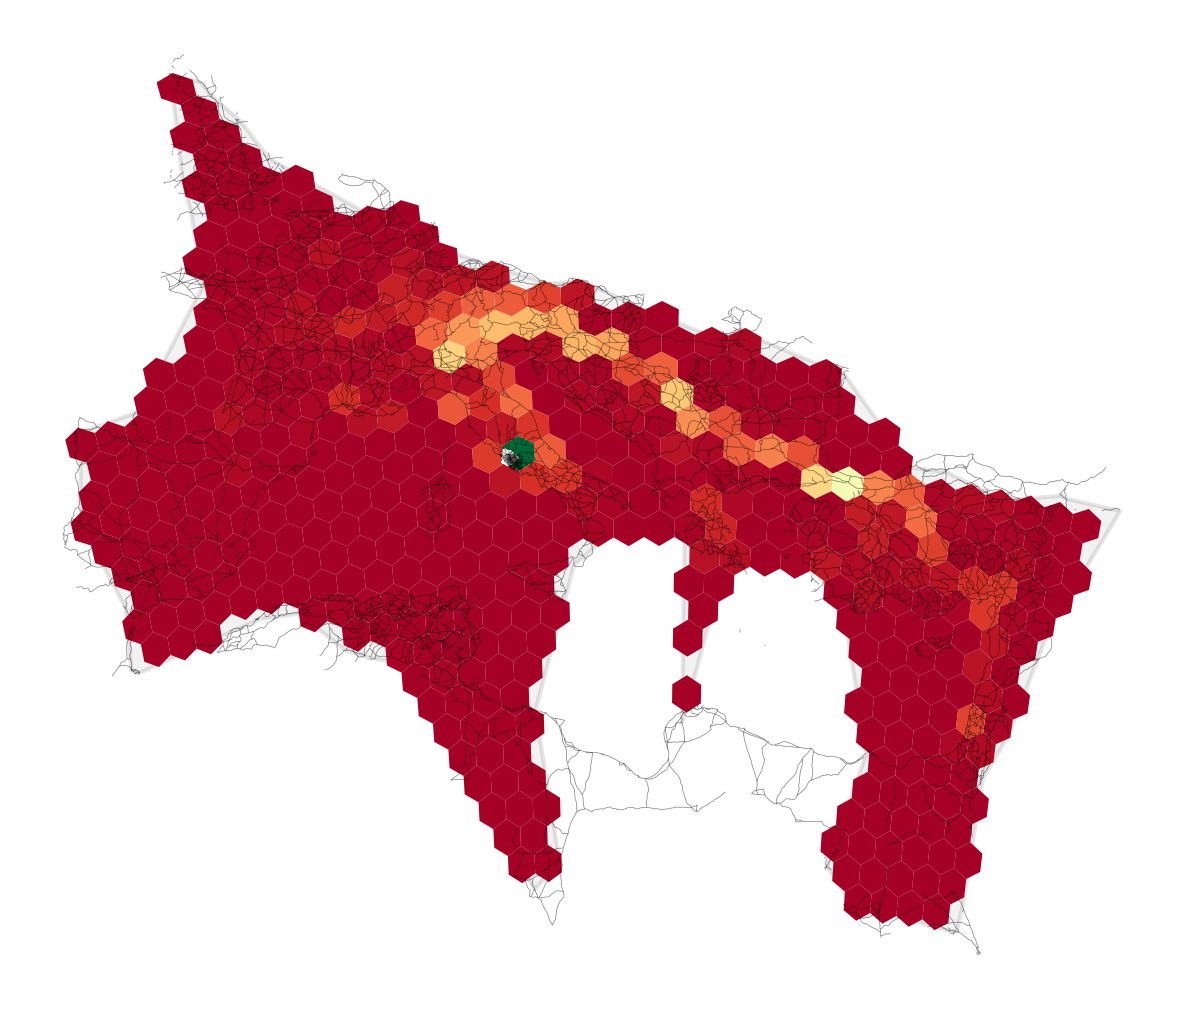

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot hull
gpd.GeoDataFrame([hull], columns=["geometry"]).plot(
    ax=ax, color="grey", edgecolor="k", linewidth=3, alpha=0.1
)

# Plot h3 cells
roman_empire.plot(column="betweenness", cmap="RdYlGn", ax=ax)

# Plot road network
gdf.plot(ax=ax, color="k", linewidth=0.5, alpha=0.5)

# Plot rome_admin boundary
rome_admin.plot(ax=ax, color="white", linewidth=3, edgecolor="white")

ax.axis("off")
plt.savefig("betweenness.png", dpi=600, bbox_inches="tight")